In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!ls /content/gdrive/My\ Drive/eva-04/S11/* 

'/content/gdrive/My Drive/eva-04/S11/Assignment11.ipynb'
'/content/gdrive/My Drive/eva-04/S11/cyclic_lr_image.png'
'/content/gdrive/My Drive/eva-04/S11/draw_cyclic_lr.py'
'/content/gdrive/My Drive/eva-04/S11/OneCycleLR.py'
'/content/gdrive/My Drive/eva-04/S11/README'

'/content/gdrive/My Drive/eva-04/S11/__pycache__':
OneCycleLR.cpython-36.pyc


We'll need to update our path to import from Drive.

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/eva-04/S11/')
#sys.path.append('/content/gdrive/My Drive/eva-04/')

# *DRAW* CyclicLR Zig-Zag or Triangle PLOT

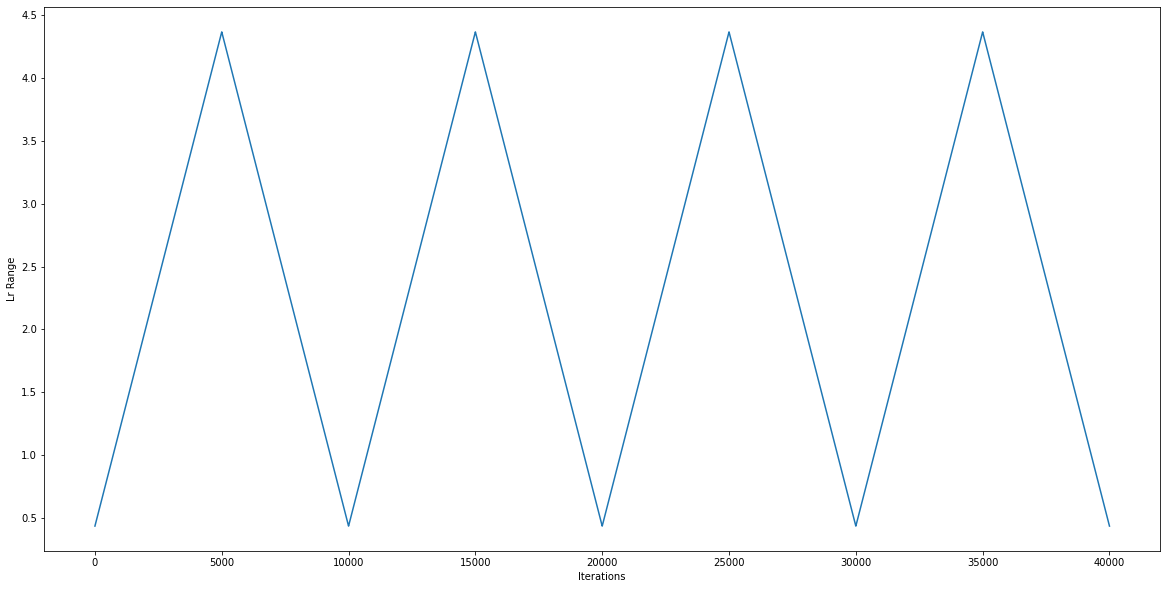

In [8]:
from CyclicLR import ZigZagPlot
# Inputs :: min LR, max LR, batch size used, number of cycles in CLR
draw_cyclic_lr_graph( lr_min = 0.4365, lr_max= 4.365, batch_size= 100, MaxNumCycles = 4)

# Implement custom model with One-Cycle LR

## Now we can import the custom model library and other functions

In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

#Import assignment 11 model
from models import ResnetA11 as resnetA11
from transformations import CIFARModel11_Alb as cifar

import importlib
importlib.reload(resnetA11)
importlib.reload(cifar)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnetA11.ResNetA11().to(device) # Model loading to device

SEED = 1
# CUDA?
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda
CUDA Available? True


##SHOW PARAMETERS

In [10]:
from utils.global_fun import test_model
from utils.global_fun import train_model
from utils.global_fun import show_summary, run_model_with_entropy_A11,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import utils.global_fun as fun
from models import ResnetA11 as resnet_a11
from transformations import CIFARModel11_Alb as cifar

import importlib
importlib.reload(resnet_a11)
importlib.reload(cifar)
importlib.reload(fun) 



criterion = torch.nn.CrossEntropyLoss()
cifar_model = cifar.CIFARModel11_Alb(model,criterion,None,None)
show_summary(cifar_model,input_size=(3,32,32))

Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13       

## **LRFinder** - Range test ( Accuracy v/s LR)

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()
Max Accuracy = 23.5 at LR = 0.008317637711026704


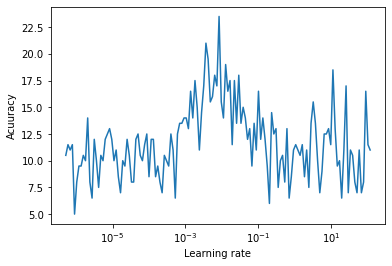

In [11]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder

#model1 = resnet_a11.ResNetA11().to(device)
#criterion1 = nn.CrossEntropyLoss()

optimizer = optim.SGD(cifar_model.m_model.parameters(), lr=1e-7)
lr_finder = lrfinder.LRFinder(cifar_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(cifar_model.m_train_loader, end_lr=100, num_iter=150, step_mode="exp")

lr_finder.plot(skip_end=0, accuracy_flag = True)
lr_finder.reset()

# One Cycle LR

In [0]:
from CyclicLR import OneCycleLR_A11
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
"""   Args:
        optimizer:             (Optimizer) against which we apply this scheduler
        batch_size:             (int) batchSize used
        num_epochs:             (int) Number of epochs
        lr_range:              (tuple) of min and max values of learning rate
        momentum_range:        (tuple) of min and max values of momentum
"""
lr_max = 0.008317637711026704
lr_min = lr_max / 10
scheduler = OneCycleLR_A11(optimizer, batch_size= 200, num_epochs= 24, lr_range=( lr_min, lr_max) , momentum_range=(0.8, 0.95))

cifar_model.setOptimizer(optimizer)
cifar_model.setScheduler(scheduler)


RUNNING WITH REGULARIZATION

In [13]:
run_model_with_entropy_A11(cifar_model, device, doL1= 0, doL2=0, LAMBDA=0, EPOCHS=24)

  0%|          | 0/250 [00:00<?, ?it/s]

EPOCH: 0

OneCyclicLR:  steps: 0/6000.0, LR: 0.0008, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 0


Loss=1.3940861225128174 Batch_id=249 Accuracy=38.90: 100%|██████████| 250/250 [00:30<00:00,  8.10it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 5487/10000 (54.87%)

EPOCH: 1

OneCyclicLR:  steps: 250/6000.0, LR: 0.0023, Momentum: 0.9200%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 1


Loss=1.2559154033660889 Batch_id=249 Accuracy=54.82: 100%|██████████| 250/250 [00:30<00:00,  8.21it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 6316/10000 (63.16%)

EPOCH: 2

OneCyclicLR:  steps: 500/6000.0, LR: 0.0038, Momentum: 0.8900%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 2


Loss=0.9453878998756409 Batch_id=249 Accuracy=61.96: 100%|██████████| 250/250 [00:30<00:00,  8.15it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 7281/10000 (72.81%)

EPOCH: 3

OneCyclicLR:  steps: 750/6000.0, LR: 0.0053, Momentum: 0.8600%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 3


Loss=1.1167713403701782 Batch_id=249 Accuracy=67.68: 100%|██████████| 250/250 [00:30<00:00,  8.21it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 7423/10000 (74.23%)

EPOCH: 4

OneCyclicLR:  steps: 1000/6000.0, LR: 0.0068, Momentum: 0.8300%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 4


Loss=0.6603524088859558 Batch_id=249 Accuracy=70.93: 100%|██████████| 250/250 [00:30<00:00,  8.12it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 7824/10000 (78.24%)

EPOCH: 5

OneCyclicLR:  steps: 1250/6000.0, LR: 0.0083, Momentum: 0.8000%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 5


Loss=0.7224096059799194 Batch_id=249 Accuracy=73.90: 100%|██████████| 250/250 [00:30<00:00,  8.27it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7734/10000 (77.34%)

EPOCH: 6

OneCyclicLR:  steps: 1500/6000.0, LR: 0.0079, Momentum: 0.8079%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 6


Loss=0.5934423208236694 Batch_id=249 Accuracy=75.94: 100%|██████████| 250/250 [00:30<00:00,  8.18it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 7833/10000 (78.33%)

EPOCH: 7

OneCyclicLR:  steps: 1750/6000.0, LR: 0.0075, Momentum: 0.8158%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 7


Loss=0.6731730103492737 Batch_id=249 Accuracy=77.43: 100%|██████████| 250/250 [00:30<00:00,  8.17it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8289/10000 (82.89%)

EPOCH: 8

OneCyclicLR:  steps: 2000/6000.0, LR: 0.0071, Momentum: 0.8237%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 8


Loss=0.47622746229171753 Batch_id=249 Accuracy=79.32: 100%|██████████| 250/250 [00:30<00:00,  8.20it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8390/10000 (83.90%)

EPOCH: 9

OneCyclicLR:  steps: 2250/6000.0, LR: 0.0067, Momentum: 0.8316%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 9


Loss=0.5333173274993896 Batch_id=249 Accuracy=80.46: 100%|██████████| 250/250 [00:30<00:00,  8.12it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8511/10000 (85.11%)

EPOCH: 10

OneCyclicLR:  steps: 2500/6000.0, LR: 0.0063, Momentum: 0.8395%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 10


Loss=0.6569615006446838 Batch_id=249 Accuracy=81.40: 100%|██████████| 250/250 [00:30<00:00,  8.18it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8530/10000 (85.30%)

EPOCH: 11

OneCyclicLR:  steps: 2750/6000.0, LR: 0.0060, Momentum: 0.8474%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 11


Loss=0.42776793241500854 Batch_id=249 Accuracy=82.55: 100%|██████████| 250/250 [00:30<00:00,  8.20it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 8673/10000 (86.73%)

EPOCH: 12

OneCyclicLR:  steps: 3000/6000.0, LR: 0.0056, Momentum: 0.8553%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 12


Loss=0.5144942402839661 Batch_id=249 Accuracy=83.40: 100%|██████████| 250/250 [00:30<00:00,  8.26it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 8620/10000 (86.20%)

EPOCH: 13

OneCyclicLR:  steps: 3250/6000.0, LR: 0.0052, Momentum: 0.8632%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 13


Loss=0.47695392370224 Batch_id=249 Accuracy=84.04: 100%|██████████| 250/250 [00:30<00:00,  8.33it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8574/10000 (85.74%)

EPOCH: 14

OneCyclicLR:  steps: 3500/6000.0, LR: 0.0048, Momentum: 0.8711%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 14


Loss=0.5100284218788147 Batch_id=249 Accuracy=84.99: 100%|██████████| 250/250 [00:30<00:00,  8.28it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 8781/10000 (87.81%)

EPOCH: 15

OneCyclicLR:  steps: 3750/6000.0, LR: 0.0044, Momentum: 0.8789%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 15


Loss=0.3784730136394501 Batch_id=249 Accuracy=85.89: 100%|██████████| 250/250 [00:30<00:00,  8.32it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 8719/10000 (87.19%)

EPOCH: 16

OneCyclicLR:  steps: 4000/6000.0, LR: 0.0040, Momentum: 0.8868%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 16


Loss=0.29554104804992676 Batch_id=249 Accuracy=86.20: 100%|██████████| 250/250 [00:30<00:00,  8.27it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 8804/10000 (88.04%)

EPOCH: 17

OneCyclicLR:  steps: 4250/6000.0, LR: 0.0036, Momentum: 0.8947%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 17


Loss=0.36044833064079285 Batch_id=249 Accuracy=86.90: 100%|██████████| 250/250 [00:30<00:00,  8.20it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 8785/10000 (87.85%)

EPOCH: 18

OneCyclicLR:  steps: 4500/6000.0, LR: 0.0032, Momentum: 0.9026%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 18


Loss=0.32868659496307373 Batch_id=249 Accuracy=87.64: 100%|██████████| 250/250 [00:30<00:00,  8.32it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8844/10000 (88.44%)

EPOCH: 19

OneCyclicLR:  steps: 4750/6000.0, LR: 0.0028, Momentum: 0.9105%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 19


Loss=0.30533066391944885 Batch_id=249 Accuracy=88.39: 100%|██████████| 250/250 [00:30<00:00,  8.26it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 8737/10000 (87.37%)

EPOCH: 20

OneCyclicLR:  steps: 5000/6000.0, LR: 0.0024, Momentum: 0.9184%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 20


Loss=0.35175982117652893 Batch_id=249 Accuracy=88.26: 100%|██████████| 250/250 [00:30<00:00,  8.19it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 8783/10000 (87.83%)

EPOCH: 21

OneCyclicLR:  steps: 5250/6000.0, LR: 0.0020, Momentum: 0.9263%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 21


Loss=0.3293282687664032 Batch_id=249 Accuracy=89.22: 100%|██████████| 250/250 [00:30<00:00,  8.30it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8898/10000 (88.98%)

EPOCH: 22

OneCyclicLR:  steps: 5500/6000.0, LR: 0.0016, Momentum: 0.9342%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 22


Loss=0.22973337769508362 Batch_id=249 Accuracy=89.83: 100%|██████████| 250/250 [00:30<00:00,  8.28it/s]
  0%|          | 0/250 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8977/10000 (89.77%)

EPOCH: 23

OneCyclicLR:  steps: 5750/6000.0, LR: 0.0012, Momentum: 0.9421%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 23


Loss=0.27125099301338196 Batch_id=249 Accuracy=90.76: 100%|██████████| 250/250 [00:29<00:00,  8.34it/s]



Test set: Average loss: 0.0015, Accuracy: 9008/10000 (90.08%)



SAVE MODEL

In [0]:
import os
state = {
    'epoch': 150,
    'state_dict': cifar_model.m_model.state_dict(),
    'optimizer': cifar_model.m_optimizer.state_dict()
}

filepath = "/content/gdrive/My Drive/eva-04/S11/"

torch.save(cifar_model.m_model.state_dict(), open(os.path.join(filepath, 'model.pt'), 'wb'))
torch.save(cifar_model.m_optimizer.state_dict(), open(os.path.join(filepath, 'optimizer.pt'), 'wb'))
torch.save(state, open(os.path.join(filepath, 'savedmodel'), 'wb'))

#model.load_state_dict(state['state_dict'])
#optimizer.load_state_dict(state['optimizer'])
#model = torch.load(filepath)
